# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

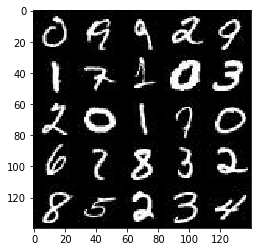

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

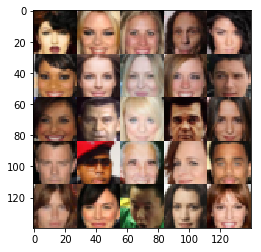

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/envs/dl/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    n_units=128
    alpha = 0.01
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        print("images.get_shape()",images.get_shape())
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits 
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

images.get_shape() (?, 28, 28, 3)
images.get_shape() (?, 28, 28, 3)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    n_units=128
    alpha = 0.01
    
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training= is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training= is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        
        # Output layer
        print("out_channel_dim",out_channel_dim)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim,3, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

out_channel_dim 5
out_channel_dim 5
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #alpha = 0.01
    
    g_model = generator(input_z, out_channel_dim)
   
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

out_channel_dim 4
images.get_shape() (?, 28, 28, 4)
images.get_shape() (?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    print ("data_shape ",data_shape)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    print_every=10
    show_every=100
    samples, losses = [], []
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                # ?????
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format( epoch_i+1,epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                #if steps % show_every == 0:
                #    gen_samples = sess.run(
                       
                #                   generator(input_z, data_shape[3], is_train=False),
                #                   feed_dict={input_z: sample_z})
                #    samples.append(gen_samples)
                #    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                #    plt.show()
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')

   
    
             

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

mnist_dataset.shape:  (60000, 28, 28, 1)
data_shape  (60000, 28, 28, 1)
out_channel_dim 1
images.get_shape() (?, 28, 28, 1)
images.get_shape() (?, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.4441... Generator Loss: 1.4039
Epoch 1/2... Discriminator Loss: 0.5083... Generator Loss: 1.3863
Epoch 1/2... Discriminator Loss: 0.4530... Generator Loss: 2.0683
Epoch 1/2... Discriminator Loss: 0.6680... Generator Loss: 0.9192
Epoch 1/2... Discriminator Loss: 0.3635... Generator Loss: 1.6636
Epoch 1/2... Discriminator Loss: 0.5005... Generator Loss: 1.6266
Epoch 1/2... Discriminator Loss: 0.5060... Generator Loss: 1.5334
Epoch 1/2... Discriminator Loss: 0.4970... Generator Loss: 1.7823
Epoch 1/2... Discriminator Loss: 0.9531... Generator Loss: 0.6479
Epoch 1/2... Discriminator Loss: 0.3866... Generator Loss: 1.7628
out_channel_dim 1


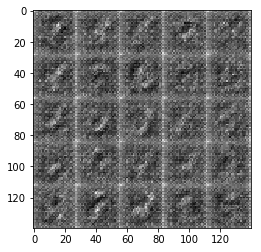

Epoch 1/2... Discriminator Loss: 0.4173... Generator Loss: 1.7381
Epoch 1/2... Discriminator Loss: 0.3150... Generator Loss: 2.5692
Epoch 1/2... Discriminator Loss: 0.3776... Generator Loss: 1.6043
Epoch 1/2... Discriminator Loss: 0.3112... Generator Loss: 1.6648
Epoch 1/2... Discriminator Loss: 0.2110... Generator Loss: 2.4636
Epoch 1/2... Discriminator Loss: 0.1920... Generator Loss: 2.2961
Epoch 1/2... Discriminator Loss: 0.1294... Generator Loss: 2.7789
Epoch 1/2... Discriminator Loss: 0.1064... Generator Loss: 3.0381
Epoch 1/2... Discriminator Loss: 0.0921... Generator Loss: 3.0689
Epoch 1/2... Discriminator Loss: 0.0703... Generator Loss: 3.2870
out_channel_dim 1


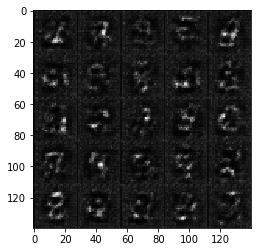

Epoch 1/2... Discriminator Loss: 0.0570... Generator Loss: 3.6434
Epoch 1/2... Discriminator Loss: 0.0840... Generator Loss: 2.9362
Epoch 1/2... Discriminator Loss: 0.0471... Generator Loss: 3.7705
Epoch 1/2... Discriminator Loss: 0.0569... Generator Loss: 3.5875
Epoch 1/2... Discriminator Loss: 7.5036... Generator Loss: 0.0020
Epoch 1/2... Discriminator Loss: 0.1148... Generator Loss: 4.2356
Epoch 1/2... Discriminator Loss: 0.0787... Generator Loss: 3.4412
Epoch 1/2... Discriminator Loss: 0.0475... Generator Loss: 4.5031
Epoch 1/2... Discriminator Loss: 0.1740... Generator Loss: 2.3976
Epoch 1/2... Discriminator Loss: 0.1085... Generator Loss: 2.6497
out_channel_dim 1


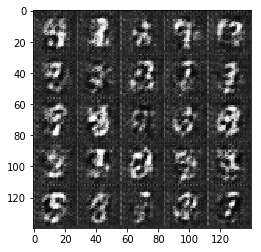

Epoch 1/2... Discriminator Loss: 0.0307... Generator Loss: 4.8825
Epoch 1/2... Discriminator Loss: 5.4678... Generator Loss: 0.0064
Epoch 1/2... Discriminator Loss: 0.2858... Generator Loss: 2.5387
Epoch 1/2... Discriminator Loss: 0.1380... Generator Loss: 3.5502
Epoch 1/2... Discriminator Loss: 0.1146... Generator Loss: 3.3056
Epoch 1/2... Discriminator Loss: 0.1051... Generator Loss: 3.7284
Epoch 1/2... Discriminator Loss: 0.0815... Generator Loss: 4.0195
Epoch 1/2... Discriminator Loss: 0.2431... Generator Loss: 1.8797
Epoch 1/2... Discriminator Loss: 0.1985... Generator Loss: 2.2389
Epoch 1/2... Discriminator Loss: 0.3095... Generator Loss: 1.5833
out_channel_dim 1


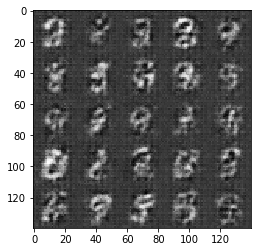

Epoch 1/2... Discriminator Loss: 0.1072... Generator Loss: 4.5771
Epoch 1/2... Discriminator Loss: 0.1048... Generator Loss: 3.3375
Epoch 1/2... Discriminator Loss: 0.1100... Generator Loss: 3.3064
Epoch 1/2... Discriminator Loss: 0.2076... Generator Loss: 2.2227
Epoch 1/2... Discriminator Loss: 0.2670... Generator Loss: 3.8675
Epoch 1/2... Discriminator Loss: 0.2163... Generator Loss: 2.0308
Epoch 1/2... Discriminator Loss: 0.1172... Generator Loss: 2.9414
Epoch 1/2... Discriminator Loss: 0.0998... Generator Loss: 3.7413
Epoch 1/2... Discriminator Loss: 0.1168... Generator Loss: 2.7485
Epoch 1/2... Discriminator Loss: 0.1846... Generator Loss: 2.6388
out_channel_dim 1


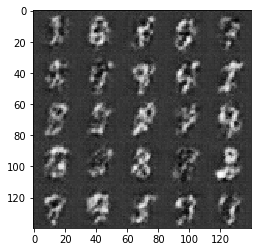

Epoch 1/2... Discriminator Loss: 0.1120... Generator Loss: 3.2371
Epoch 1/2... Discriminator Loss: 0.1180... Generator Loss: 2.9925
Epoch 1/2... Discriminator Loss: 0.1053... Generator Loss: 3.0133
Epoch 1/2... Discriminator Loss: 0.1075... Generator Loss: 3.0664
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 0.5063
Epoch 1/2... Discriminator Loss: 0.2557... Generator Loss: 2.2276
Epoch 1/2... Discriminator Loss: 0.1941... Generator Loss: 2.4605
Epoch 1/2... Discriminator Loss: 0.1810... Generator Loss: 2.7991
Epoch 1/2... Discriminator Loss: 0.1645... Generator Loss: 2.7244
Epoch 1/2... Discriminator Loss: 0.1464... Generator Loss: 2.7898
out_channel_dim 1


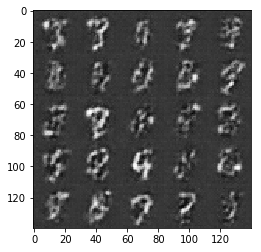

Epoch 1/2... Discriminator Loss: 0.1439... Generator Loss: 2.8052
Epoch 1/2... Discriminator Loss: 0.0969... Generator Loss: 3.3015
Epoch 1/2... Discriminator Loss: 0.1092... Generator Loss: 2.9301
Epoch 1/2... Discriminator Loss: 0.1230... Generator Loss: 2.9222
Epoch 1/2... Discriminator Loss: 0.1070... Generator Loss: 3.1572
Epoch 1/2... Discriminator Loss: 0.1087... Generator Loss: 3.1422
Epoch 1/2... Discriminator Loss: 0.0945... Generator Loss: 3.3447
Epoch 1/2... Discriminator Loss: 0.2250... Generator Loss: 2.2097
Epoch 1/2... Discriminator Loss: 0.0824... Generator Loss: 3.7388
Epoch 1/2... Discriminator Loss: 0.0611... Generator Loss: 4.0588
out_channel_dim 1


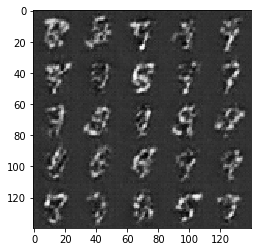

Epoch 1/2... Discriminator Loss: 0.1092... Generator Loss: 3.7010
Epoch 1/2... Discriminator Loss: 0.1189... Generator Loss: 3.0894
Epoch 1/2... Discriminator Loss: 0.1001... Generator Loss: 3.3790
Epoch 1/2... Discriminator Loss: 0.1008... Generator Loss: 3.1318
Epoch 1/2... Discriminator Loss: 0.1129... Generator Loss: 2.8383
Epoch 1/2... Discriminator Loss: 0.1200... Generator Loss: 3.2082
Epoch 1/2... Discriminator Loss: 0.0725... Generator Loss: 3.4059
Epoch 1/2... Discriminator Loss: 0.0851... Generator Loss: 3.7121
Epoch 1/2... Discriminator Loss: 0.0712... Generator Loss: 4.2369
Epoch 1/2... Discriminator Loss: 0.0726... Generator Loss: 3.3326
out_channel_dim 1


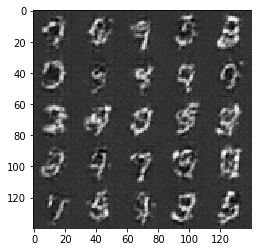

Epoch 1/2... Discriminator Loss: 0.0862... Generator Loss: 3.2630
Epoch 1/2... Discriminator Loss: 0.0713... Generator Loss: 3.4231
Epoch 1/2... Discriminator Loss: 0.0938... Generator Loss: 4.1176
Epoch 1/2... Discriminator Loss: 0.0775... Generator Loss: 3.4273
Epoch 1/2... Discriminator Loss: 0.0634... Generator Loss: 3.7575
Epoch 1/2... Discriminator Loss: 0.0422... Generator Loss: 4.5794
Epoch 1/2... Discriminator Loss: 0.0556... Generator Loss: 4.1686
Epoch 1/2... Discriminator Loss: 0.0732... Generator Loss: 4.1160
Epoch 1/2... Discriminator Loss: 0.0770... Generator Loss: 3.4418
Epoch 1/2... Discriminator Loss: 0.0734... Generator Loss: 3.7912
out_channel_dim 1


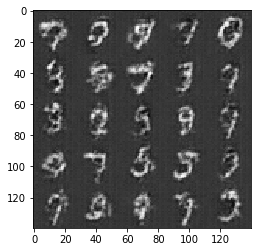

Epoch 1/2... Discriminator Loss: 0.1643... Generator Loss: 2.3244
Epoch 1/2... Discriminator Loss: 0.0731... Generator Loss: 3.6352
Epoch 1/2... Discriminator Loss: 0.0755... Generator Loss: 3.4253
Epoch 2/2... Discriminator Loss: 0.0387... Generator Loss: 4.2509
Epoch 2/2... Discriminator Loss: 0.0749... Generator Loss: 3.4702
Epoch 2/2... Discriminator Loss: 0.0582... Generator Loss: 4.7112
Epoch 2/2... Discriminator Loss: 0.1427... Generator Loss: 5.3528
Epoch 2/2... Discriminator Loss: 0.2857... Generator Loss: 2.5612
Epoch 2/2... Discriminator Loss: 0.0517... Generator Loss: 4.2889
Epoch 2/2... Discriminator Loss: 0.1503... Generator Loss: 3.5477
out_channel_dim 1


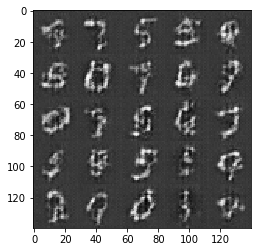

Epoch 2/2... Discriminator Loss: 0.0896... Generator Loss: 3.6753
Epoch 2/2... Discriminator Loss: 0.0854... Generator Loss: 3.3961
Epoch 2/2... Discriminator Loss: 0.1498... Generator Loss: 2.5993
Epoch 2/2... Discriminator Loss: 0.1056... Generator Loss: 3.0531
Epoch 2/2... Discriminator Loss: 0.0832... Generator Loss: 3.1534
Epoch 2/2... Discriminator Loss: 0.1368... Generator Loss: 2.9264
Epoch 2/2... Discriminator Loss: 0.1378... Generator Loss: 2.6897
Epoch 2/2... Discriminator Loss: 0.1083... Generator Loss: 3.1158
Epoch 2/2... Discriminator Loss: 0.1041... Generator Loss: 3.3685
Epoch 2/2... Discriminator Loss: 0.1152... Generator Loss: 2.8868
out_channel_dim 1


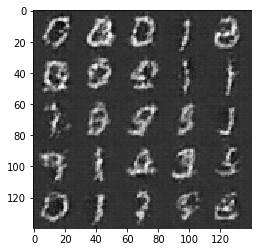

Epoch 2/2... Discriminator Loss: 0.0917... Generator Loss: 3.3956
Epoch 2/2... Discriminator Loss: 0.0749... Generator Loss: 3.4940
Epoch 2/2... Discriminator Loss: 0.1306... Generator Loss: 2.8961
Epoch 2/2... Discriminator Loss: 0.0865... Generator Loss: 3.4105
Epoch 2/2... Discriminator Loss: 0.1078... Generator Loss: 2.8714
Epoch 2/2... Discriminator Loss: 0.1051... Generator Loss: 3.0106
Epoch 2/2... Discriminator Loss: 0.0831... Generator Loss: 3.4904
Epoch 2/2... Discriminator Loss: 0.0848... Generator Loss: 3.2150
Epoch 2/2... Discriminator Loss: 0.0534... Generator Loss: 3.8619
Epoch 2/2... Discriminator Loss: 0.1573... Generator Loss: 2.3925
out_channel_dim 1


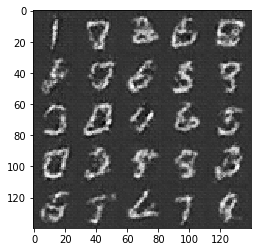

Epoch 2/2... Discriminator Loss: 0.1111... Generator Loss: 2.8182
Epoch 2/2... Discriminator Loss: 0.1785... Generator Loss: 2.4227
Epoch 2/2... Discriminator Loss: 0.0821... Generator Loss: 3.1890
Epoch 2/2... Discriminator Loss: 0.0536... Generator Loss: 4.8008
Epoch 2/2... Discriminator Loss: 0.1414... Generator Loss: 2.5713
Epoch 2/2... Discriminator Loss: 0.2157... Generator Loss: 2.0402
Epoch 2/2... Discriminator Loss: 0.0558... Generator Loss: 4.6870
Epoch 2/2... Discriminator Loss: 0.4565... Generator Loss: 4.3212
Epoch 2/2... Discriminator Loss: 0.1497... Generator Loss: 3.0559
Epoch 2/2... Discriminator Loss: 0.2538... Generator Loss: 1.9599
out_channel_dim 1


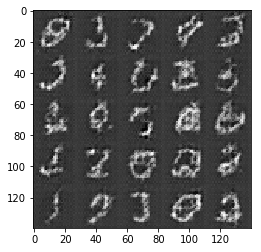

Epoch 2/2... Discriminator Loss: 0.2330... Generator Loss: 2.0871
Epoch 2/2... Discriminator Loss: 0.3024... Generator Loss: 1.8524
Epoch 2/2... Discriminator Loss: 0.1756... Generator Loss: 2.4072
Epoch 2/2... Discriminator Loss: 0.2886... Generator Loss: 3.1798
Epoch 2/2... Discriminator Loss: 0.2045... Generator Loss: 3.0232
Epoch 2/2... Discriminator Loss: 0.2037... Generator Loss: 2.3028
Epoch 2/2... Discriminator Loss: 0.2645... Generator Loss: 1.8900
Epoch 2/2... Discriminator Loss: 0.2489... Generator Loss: 1.9476
Epoch 2/2... Discriminator Loss: 0.2083... Generator Loss: 2.0669
Epoch 2/2... Discriminator Loss: 0.1766... Generator Loss: 2.4025
out_channel_dim 1


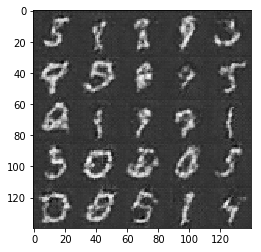

Epoch 2/2... Discriminator Loss: 0.1425... Generator Loss: 2.6182
Epoch 2/2... Discriminator Loss: 0.2169... Generator Loss: 2.5972
Epoch 2/2... Discriminator Loss: 0.2303... Generator Loss: 2.1014
Epoch 2/2... Discriminator Loss: 0.1464... Generator Loss: 2.6715
Epoch 2/2... Discriminator Loss: 0.3100... Generator Loss: 1.6918
Epoch 2/2... Discriminator Loss: 0.1338... Generator Loss: 3.0403
Epoch 2/2... Discriminator Loss: 0.2969... Generator Loss: 1.7285
Epoch 2/2... Discriminator Loss: 0.1348... Generator Loss: 2.8801
Epoch 2/2... Discriminator Loss: 0.1490... Generator Loss: 2.8804
Epoch 2/2... Discriminator Loss: 0.1626... Generator Loss: 2.6107
out_channel_dim 1


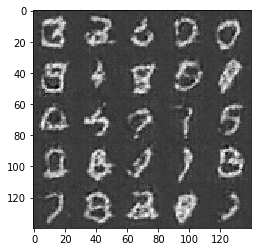

Epoch 2/2... Discriminator Loss: 0.5635... Generator Loss: 1.1099
Epoch 2/2... Discriminator Loss: 0.1660... Generator Loss: 2.6336
Epoch 2/2... Discriminator Loss: 0.4066... Generator Loss: 1.8594
Epoch 2/2... Discriminator Loss: 0.2105... Generator Loss: 2.2539
Epoch 2/2... Discriminator Loss: 0.2335... Generator Loss: 2.0996
Epoch 2/2... Discriminator Loss: 0.2037... Generator Loss: 2.3322
Epoch 2/2... Discriminator Loss: 0.1307... Generator Loss: 2.7753
Epoch 2/2... Discriminator Loss: 0.2076... Generator Loss: 2.1722
Epoch 2/2... Discriminator Loss: 0.1765... Generator Loss: 2.4026
Epoch 2/2... Discriminator Loss: 0.1225... Generator Loss: 3.0683
out_channel_dim 1


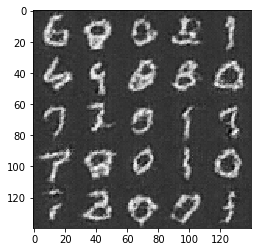

Epoch 2/2... Discriminator Loss: 0.1471... Generator Loss: 2.4957
Epoch 2/2... Discriminator Loss: 0.1083... Generator Loss: 3.4498
Epoch 2/2... Discriminator Loss: 0.0966... Generator Loss: 2.9963
Epoch 2/2... Discriminator Loss: 0.1279... Generator Loss: 2.6461
Epoch 2/2... Discriminator Loss: 0.1093... Generator Loss: 2.8872
Epoch 2/2... Discriminator Loss: 0.1299... Generator Loss: 3.1967
Epoch 2/2... Discriminator Loss: 0.0620... Generator Loss: 3.3964
Epoch 2/2... Discriminator Loss: 0.0840... Generator Loss: 3.7407
Epoch 2/2... Discriminator Loss: 0.0633... Generator Loss: 3.5570
Epoch 2/2... Discriminator Loss: 0.1018... Generator Loss: 3.1217
out_channel_dim 1


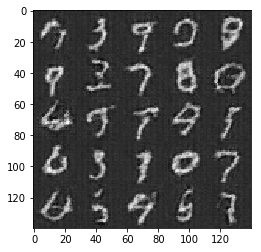

Epoch 2/2... Discriminator Loss: 0.1341... Generator Loss: 2.6512
Epoch 2/2... Discriminator Loss: 0.0584... Generator Loss: 3.4952
Epoch 2/2... Discriminator Loss: 0.1209... Generator Loss: 2.8275
Epoch 2/2... Discriminator Loss: 0.6508... Generator Loss: 6.1023
Epoch 2/2... Discriminator Loss: 0.3820... Generator Loss: 3.9185
Epoch 2/2... Discriminator Loss: 0.2972... Generator Loss: 2.2003
Epoch 2/2... Discriminator Loss: 0.2424... Generator Loss: 2.1513
Epoch 2/2... Discriminator Loss: 0.1682... Generator Loss: 2.6235
Epoch 2/2... Discriminator Loss: 0.1767... Generator Loss: 2.6549
Epoch 2/2... Discriminator Loss: 0.1785... Generator Loss: 2.4920
out_channel_dim 1


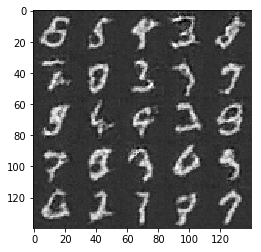

Epoch 2/2... Discriminator Loss: 0.2199... Generator Loss: 2.1880
Epoch 2/2... Discriminator Loss: 0.2501... Generator Loss: 1.9935
Epoch 2/2... Discriminator Loss: 0.0860... Generator Loss: 3.4582
Epoch 2/2... Discriminator Loss: 0.1738... Generator Loss: 2.4221
Epoch 2/2... Discriminator Loss: 0.1772... Generator Loss: 2.4235
Epoch 2/2... Discriminator Loss: 0.0903... Generator Loss: 3.6405
Epoch 2/2... Discriminator Loss: 0.1353... Generator Loss: 2.8580


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print("mnist_dataset.shape: ", mnist_dataset.shape)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data_shape  (202599, 28, 28, 3)
out_channel_dim 3
images.get_shape() (?, 28, 28, 3)
images.get_shape() (?, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 0.2917... Generator Loss: 1.6363
Epoch 1/1... Discriminator Loss: 0.2617... Generator Loss: 1.8252
Epoch 1/1... Discriminator Loss: 0.2643... Generator Loss: 1.7996
Epoch 1/1... Discriminator Loss: 0.1852... Generator Loss: 2.0897
Epoch 1/1... Discriminator Loss: 0.1937... Generator Loss: 2.3789
Epoch 1/1... Discriminator Loss: 0.0672... Generator Loss: 3.6394
Epoch 1/1... Discriminator Loss: 0.2162... Generator Loss: 2.0539
Epoch 1/1... Discriminator Loss: 0.0463... Generator Loss: 3.5034
Epoch 1/1... Discriminator Loss: 0.0622... Generator Loss: 3.4007
Epoch 1/1... Discriminator Loss: 0.1723... Generator Loss: 2.2939
out_channel_dim 3


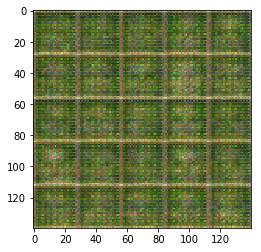

Epoch 1/1... Discriminator Loss: 0.0451... Generator Loss: 4.8685
Epoch 1/1... Discriminator Loss: 0.1168... Generator Loss: 2.8196
Epoch 1/1... Discriminator Loss: 0.4044... Generator Loss: 1.8243
Epoch 1/1... Discriminator Loss: 0.1038... Generator Loss: 4.0935
Epoch 1/1... Discriminator Loss: 0.1145... Generator Loss: 3.2036
Epoch 1/1... Discriminator Loss: 0.1041... Generator Loss: 3.1393
Epoch 1/1... Discriminator Loss: 0.1030... Generator Loss: 2.8576
Epoch 1/1... Discriminator Loss: 0.0778... Generator Loss: 3.2178
Epoch 1/1... Discriminator Loss: 0.0779... Generator Loss: 5.1022
Epoch 1/1... Discriminator Loss: 0.0612... Generator Loss: 3.2979
out_channel_dim 3


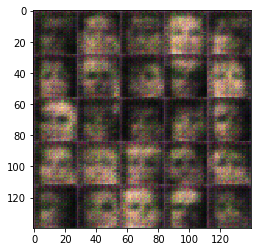

Epoch 1/1... Discriminator Loss: 0.1101... Generator Loss: 4.6777
Epoch 1/1... Discriminator Loss: 0.0384... Generator Loss: 3.8305
Epoch 1/1... Discriminator Loss: 0.2848... Generator Loss: 2.5414
Epoch 1/1... Discriminator Loss: 0.0636... Generator Loss: 3.8566
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 7.4495
Epoch 1/1... Discriminator Loss: 0.0613... Generator Loss: 3.7959
Epoch 1/1... Discriminator Loss: 0.0769... Generator Loss: 5.1013
Epoch 1/1... Discriminator Loss: 0.0792... Generator Loss: 3.2991
Epoch 1/1... Discriminator Loss: 0.0534... Generator Loss: 6.0790
out_channel_dim 3


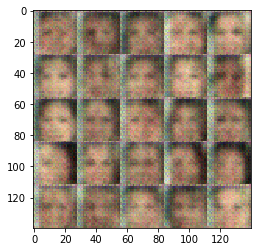

Epoch 1/1... Discriminator Loss: 0.1738... Generator Loss: 3.4891
Epoch 1/1... Discriminator Loss: 0.0903... Generator Loss: 6.4748
Epoch 1/1... Discriminator Loss: 0.1647... Generator Loss: 7.8479
Epoch 1/1... Discriminator Loss: 0.2079... Generator Loss: 2.0398
Epoch 1/1... Discriminator Loss: 0.1080... Generator Loss: 4.7819
Epoch 1/1... Discriminator Loss: 0.4147... Generator Loss: 1.3489
Epoch 1/1... Discriminator Loss: 0.1618... Generator Loss: 3.2134
Epoch 1/1... Discriminator Loss: 0.5169... Generator Loss: 1.7959
Epoch 1/1... Discriminator Loss: 0.4417... Generator Loss: 1.7379
Epoch 1/1... Discriminator Loss: 0.0615... Generator Loss: 8.3259
out_channel_dim 3


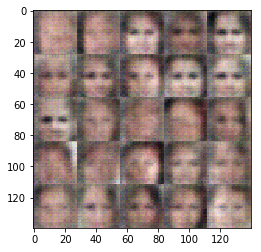

Epoch 1/1... Discriminator Loss: 0.2880... Generator Loss: 1.9044
Epoch 1/1... Discriminator Loss: 0.0751... Generator Loss: 5.4457
Epoch 1/1... Discriminator Loss: 0.4610... Generator Loss: 1.6501
Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 0.3640... Generator Loss: 3.2616
Epoch 1/1... Discriminator Loss: 0.7024... Generator Loss: 1.0654
Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 1.7621
Epoch 1/1... Discriminator Loss: 0.2431... Generator Loss: 2.7161
Epoch 1/1... Discriminator Loss: 0.3242... Generator Loss: 2.1914
Epoch 1/1... Discriminator Loss: 0.4505... Generator Loss: 1.3733
out_channel_dim 3


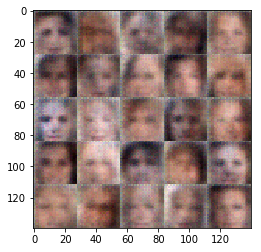

Epoch 1/1... Discriminator Loss: 0.0502... Generator Loss: 6.7544
Epoch 1/1... Discriminator Loss: 0.3870... Generator Loss: 1.6469
Epoch 1/1... Discriminator Loss: 0.3502... Generator Loss: 1.6790
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 0.1889... Generator Loss: 3.0455
Epoch 1/1... Discriminator Loss: 0.0442... Generator Loss: 5.2646
Epoch 1/1... Discriminator Loss: 0.2329... Generator Loss: 4.4917
Epoch 1/1... Discriminator Loss: 0.0441... Generator Loss: 4.5932
Epoch 1/1... Discriminator Loss: 0.0604... Generator Loss: 3.6390
Epoch 1/1... Discriminator Loss: 0.0558... Generator Loss: 3.8265
out_channel_dim 3


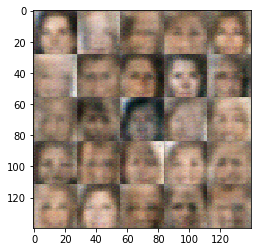

Epoch 1/1... Discriminator Loss: 0.1244... Generator Loss: 5.6269
Epoch 1/1... Discriminator Loss: 0.0807... Generator Loss: 5.4110
Epoch 1/1... Discriminator Loss: 0.1254... Generator Loss: 2.7783
Epoch 1/1... Discriminator Loss: 0.0620... Generator Loss: 4.5008
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 6.4480
Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 7.2060
Epoch 1/1... Discriminator Loss: 0.2136... Generator Loss: 2.1651
Epoch 1/1... Discriminator Loss: 0.2399... Generator Loss: 2.3922
Epoch 1/1... Discriminator Loss: 0.1674... Generator Loss: 4.2874
Epoch 1/1... Discriminator Loss: 0.1935... Generator Loss: 2.7384
out_channel_dim 3


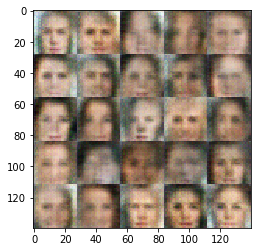

Epoch 1/1... Discriminator Loss: 0.1304... Generator Loss: 4.7902
Epoch 1/1... Discriminator Loss: 0.5922... Generator Loss: 1.5030
Epoch 1/1... Discriminator Loss: 0.3462... Generator Loss: 1.8346
Epoch 1/1... Discriminator Loss: 0.2109... Generator Loss: 3.2224
Epoch 1/1... Discriminator Loss: 0.0710... Generator Loss: 3.5232
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 0.1747... Generator Loss: 2.5930
Epoch 1/1... Discriminator Loss: 0.0697... Generator Loss: 5.0544
Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 4.8407
Epoch 1/1... Discriminator Loss: 0.2453... Generator Loss: 4.8828
out_channel_dim 3


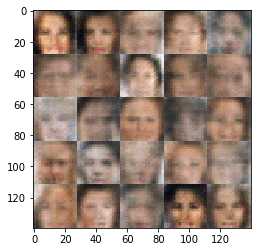

Epoch 1/1... Discriminator Loss: 0.4025... Generator Loss: 1.6808
Epoch 1/1... Discriminator Loss: 0.0696... Generator Loss: 4.5614
Epoch 1/1... Discriminator Loss: 0.2726... Generator Loss: 2.0761
Epoch 1/1... Discriminator Loss: 0.0651... Generator Loss: 6.7120
Epoch 1/1... Discriminator Loss: 0.0444... Generator Loss: 9.0789
Epoch 1/1... Discriminator Loss: 0.2061... Generator Loss: 2.1505
Epoch 1/1... Discriminator Loss: 0.1183... Generator Loss: 3.0586
Epoch 1/1... Discriminator Loss: 0.3491... Generator Loss: 1.7853
Epoch 1/1... Discriminator Loss: 0.3097... Generator Loss: 4.3226
Epoch 1/1... Discriminator Loss: 0.5824... Generator Loss: 5.2865
out_channel_dim 3


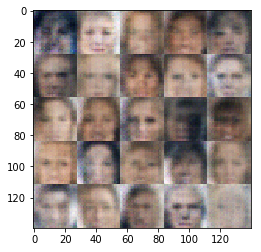

Epoch 1/1... Discriminator Loss: 0.1288... Generator Loss: 3.1584
Epoch 1/1... Discriminator Loss: 0.3032... Generator Loss: 1.7932
Epoch 1/1... Discriminator Loss: 0.0957... Generator Loss: 7.0376
Epoch 1/1... Discriminator Loss: 0.0468... Generator Loss: 4.6034
Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 0.0869... Generator Loss: 7.1870
Epoch 1/1... Discriminator Loss: 1.5972... Generator Loss: 0.4484
Epoch 1/1... Discriminator Loss: 0.2004... Generator Loss: 2.5402
Epoch 1/1... Discriminator Loss: 0.3344... Generator Loss: 1.7635
out_channel_dim 3


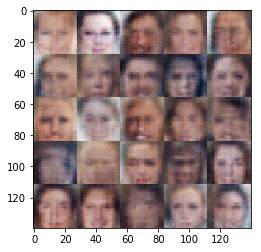

Epoch 1/1... Discriminator Loss: 0.2148... Generator Loss: 2.2439
Epoch 1/1... Discriminator Loss: 0.1036... Generator Loss: 3.4255
Epoch 1/1... Discriminator Loss: 0.1104... Generator Loss: 3.1247
Epoch 1/1... Discriminator Loss: 0.5702... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 0.1575... Generator Loss: 3.2414
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 0.0965... Generator Loss: 4.2981
Epoch 1/1... Discriminator Loss: 0.2760... Generator Loss: 1.9769
Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 8.4146
Epoch 1/1... Discriminator Loss: 0.1047... Generator Loss: 4.0188
out_channel_dim 3


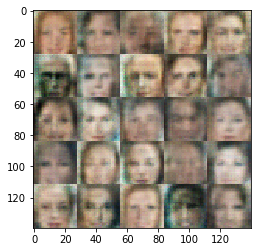

Epoch 1/1... Discriminator Loss: 0.0599... Generator Loss: 3.8726
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 10.4975
Epoch 1/1... Discriminator Loss: 0.1368... Generator Loss: 4.3734
Epoch 1/1... Discriminator Loss: 0.0555... Generator Loss: 4.2335
Epoch 1/1... Discriminator Loss: 0.2613... Generator Loss: 5.1582
Epoch 1/1... Discriminator Loss: 0.8268... Generator Loss: 5.0397
Epoch 1/1... Discriminator Loss: 0.5276... Generator Loss: 1.2023
Epoch 1/1... Discriminator Loss: 0.1417... Generator Loss: 4.4019
Epoch 1/1... Discriminator Loss: 0.6891... Generator Loss: 1.0787
Epoch 1/1... Discriminator Loss: 0.0975... Generator Loss: 4.0882
out_channel_dim 3


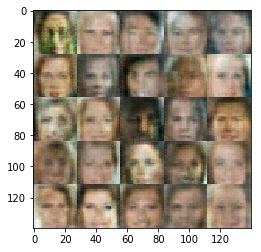

Epoch 1/1... Discriminator Loss: 0.2464... Generator Loss: 2.1523
Epoch 1/1... Discriminator Loss: 0.0793... Generator Loss: 4.2524
Epoch 1/1... Discriminator Loss: 0.2749... Generator Loss: 3.0483
Epoch 1/1... Discriminator Loss: 0.1463... Generator Loss: 10.7217
Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 0.0856... Generator Loss: 4.2378
Epoch 1/1... Discriminator Loss: 0.3533... Generator Loss: 1.9754
Epoch 1/1... Discriminator Loss: 0.0197... Generator Loss: 10.1419
Epoch 1/1... Discriminator Loss: 0.0230... Generator Loss: 8.0469
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.4846
out_channel_dim 3


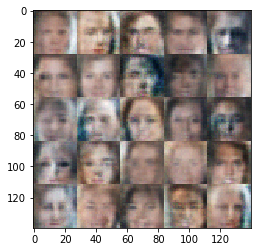

Epoch 1/1... Discriminator Loss: 0.1318... Generator Loss: 6.0389
Epoch 1/1... Discriminator Loss: 0.1005... Generator Loss: 3.4076
Epoch 1/1... Discriminator Loss: 0.1273... Generator Loss: 3.1039
Epoch 1/1... Discriminator Loss: 0.0563... Generator Loss: 5.1169
Epoch 1/1... Discriminator Loss: 0.1860... Generator Loss: 2.4266
Epoch 1/1... Discriminator Loss: 0.0723... Generator Loss: 6.0837
Epoch 1/1... Discriminator Loss: 0.1605... Generator Loss: 3.3410
Epoch 1/1... Discriminator Loss: 0.5623... Generator Loss: 4.1892
Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 1.6920
Epoch 1/1... Discriminator Loss: 0.0937... Generator Loss: 3.3384
out_channel_dim 3


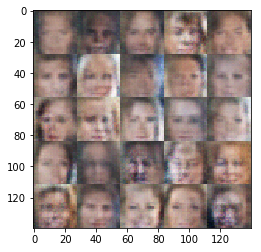

Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 0.5122... Generator Loss: 3.5728
Epoch 1/1... Discriminator Loss: 0.1850... Generator Loss: 2.2396
Epoch 1/1... Discriminator Loss: 0.0867... Generator Loss: 3.3380
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 0.3105... Generator Loss: 1.9110
Epoch 1/1... Discriminator Loss: 0.1806... Generator Loss: 3.9537
Epoch 1/1... Discriminator Loss: 0.2709... Generator Loss: 2.3989
Epoch 1/1... Discriminator Loss: 0.1214... Generator Loss: 4.2672
Epoch 1/1... Discriminator Loss: 0.1361... Generator Loss: 4.3392
out_channel_dim 3


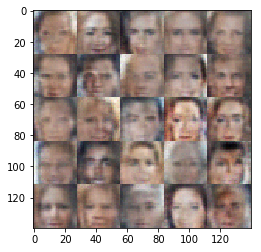

Epoch 1/1... Discriminator Loss: 0.3131... Generator Loss: 1.8801
Epoch 1/1... Discriminator Loss: 0.0586... Generator Loss: 4.4626
Epoch 1/1... Discriminator Loss: 0.0249... Generator Loss: 4.8710
Epoch 1/1... Discriminator Loss: 0.4096... Generator Loss: 1.4145
Epoch 1/1... Discriminator Loss: 0.4720... Generator Loss: 1.2632
Epoch 1/1... Discriminator Loss: 0.0130... Generator Loss: 8.1131
Epoch 1/1... Discriminator Loss: 0.2011... Generator Loss: 4.8600
Epoch 1/1... Discriminator Loss: 0.0936... Generator Loss: 3.4530
Epoch 1/1... Discriminator Loss: 0.1944... Generator Loss: 3.6927
Epoch 1/1... Discriminator Loss: 0.3582... Generator Loss: 1.6644
out_channel_dim 3


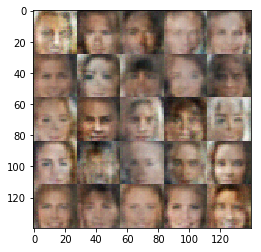

Epoch 1/1... Discriminator Loss: 0.1210... Generator Loss: 3.6007
Epoch 1/1... Discriminator Loss: 0.0637... Generator Loss: 5.0150
Epoch 1/1... Discriminator Loss: 0.2258... Generator Loss: 2.6629
Epoch 1/1... Discriminator Loss: 0.2349... Generator Loss: 2.2528
Epoch 1/1... Discriminator Loss: 0.4290... Generator Loss: 4.1351
Epoch 1/1... Discriminator Loss: 0.2615... Generator Loss: 2.4927
Epoch 1/1... Discriminator Loss: 0.4238... Generator Loss: 1.3696
Epoch 1/1... Discriminator Loss: 0.1588... Generator Loss: 4.3438
Epoch 1/1... Discriminator Loss: 0.1565... Generator Loss: 5.5679
Epoch 1/1... Discriminator Loss: 0.0299... Generator Loss: 4.8898
out_channel_dim 3


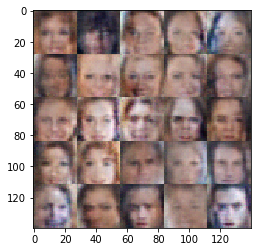

Epoch 1/1... Discriminator Loss: 1.5773... Generator Loss: 0.3722
Epoch 1/1... Discriminator Loss: 0.0610... Generator Loss: 4.7720
Epoch 1/1... Discriminator Loss: 0.2642... Generator Loss: 2.1570
Epoch 1/1... Discriminator Loss: 0.0671... Generator Loss: 3.6104
Epoch 1/1... Discriminator Loss: 0.2859... Generator Loss: 2.6411
Epoch 1/1... Discriminator Loss: 0.5044... Generator Loss: 3.0116
Epoch 1/1... Discriminator Loss: 0.3671... Generator Loss: 2.7448
Epoch 1/1... Discriminator Loss: 0.0722... Generator Loss: 3.3496
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.4351
Epoch 1/1... Discriminator Loss: 0.1009... Generator Loss: 3.1023
out_channel_dim 3


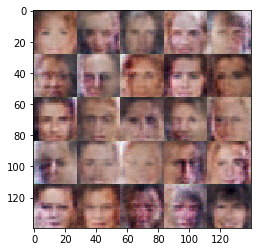

Epoch 1/1... Discriminator Loss: 0.2832... Generator Loss: 3.9722
Epoch 1/1... Discriminator Loss: 0.2660... Generator Loss: 3.5371
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 0.2661... Generator Loss: 1.9092
Epoch 1/1... Discriminator Loss: 0.1269... Generator Loss: 2.6108
Epoch 1/1... Discriminator Loss: 0.0153... Generator Loss: 12.0935
Epoch 1/1... Discriminator Loss: 0.0237... Generator Loss: 6.0266
Epoch 1/1... Discriminator Loss: 0.5630... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 2.8718... Generator Loss: 2.1191
Epoch 1/1... Discriminator Loss: 0.2010... Generator Loss: 2.3744
out_channel_dim 3


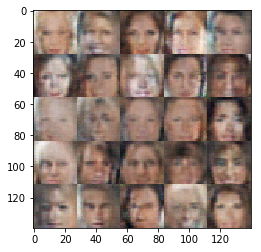

Epoch 1/1... Discriminator Loss: 0.2351... Generator Loss: 2.1443
Epoch 1/1... Discriminator Loss: 0.0913... Generator Loss: 6.5465
Epoch 1/1... Discriminator Loss: 0.0741... Generator Loss: 8.2129
Epoch 1/1... Discriminator Loss: 0.0186... Generator Loss: 9.1590
Epoch 1/1... Discriminator Loss: 0.1238... Generator Loss: 3.3094
Epoch 1/1... Discriminator Loss: 0.1340... Generator Loss: 6.8203
Epoch 1/1... Discriminator Loss: 0.1314... Generator Loss: 2.8896
Epoch 1/1... Discriminator Loss: 0.7734... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 0.0783... Generator Loss: 7.6443
Epoch 1/1... Discriminator Loss: 0.1446... Generator Loss: 3.1839
out_channel_dim 3


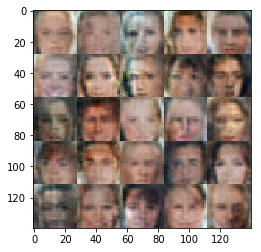

Epoch 1/1... Discriminator Loss: 0.1570... Generator Loss: 2.2693
Epoch 1/1... Discriminator Loss: 1.7228... Generator Loss: 0.3070
Epoch 1/1... Discriminator Loss: 0.1100... Generator Loss: 4.2971
Epoch 1/1... Discriminator Loss: 0.0586... Generator Loss: 8.2927
Epoch 1/1... Discriminator Loss: 0.1984... Generator Loss: 4.9869
Epoch 1/1... Discriminator Loss: 0.0470... Generator Loss: 7.5893
Epoch 1/1... Discriminator Loss: 0.4435... Generator Loss: 1.2936
Epoch 1/1... Discriminator Loss: 0.1038... Generator Loss: 3.3858
Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 6.5334
Epoch 1/1... Discriminator Loss: 0.2650... Generator Loss: 1.9409
out_channel_dim 3


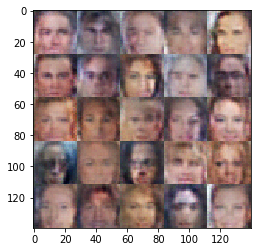

Epoch 1/1... Discriminator Loss: 0.2676... Generator Loss: 6.6690
Epoch 1/1... Discriminator Loss: 0.1481... Generator Loss: 3.0135
Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 7.9333
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 3.1626
Epoch 1/1... Discriminator Loss: 0.0310... Generator Loss: 6.1075
Epoch 1/1... Discriminator Loss: 0.0736... Generator Loss: 6.1062
Epoch 1/1... Discriminator Loss: 0.1237... Generator Loss: 2.4059
Epoch 1/1... Discriminator Loss: 0.1242... Generator Loss: 6.1641
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 0.1961... Generator Loss: 2.2878
out_channel_dim 3


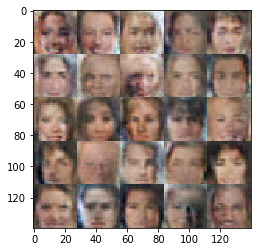

Epoch 1/1... Discriminator Loss: 0.1797... Generator Loss: 2.4378
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 1.3910
Epoch 1/1... Discriminator Loss: 0.0858... Generator Loss: 3.6545
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 0.2068... Generator Loss: 3.7350
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 0.2319... Generator Loss: 2.6130
Epoch 1/1... Discriminator Loss: 0.5674... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 0.2642... Generator Loss: 5.6963
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 5.1689
out_channel_dim 3


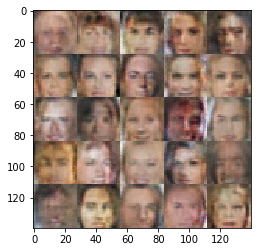

Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 1.9338
Epoch 1/1... Discriminator Loss: 0.4094... Generator Loss: 2.0238
Epoch 1/1... Discriminator Loss: 0.3377... Generator Loss: 1.6501
Epoch 1/1... Discriminator Loss: 0.0321... Generator Loss: 7.5033
Epoch 1/1... Discriminator Loss: 0.0527... Generator Loss: 4.5477
Epoch 1/1... Discriminator Loss: 0.0209... Generator Loss: 4.9343
Epoch 1/1... Discriminator Loss: 0.2253... Generator Loss: 2.5168
Epoch 1/1... Discriminator Loss: 0.0870... Generator Loss: 3.4751
Epoch 1/1... Discriminator Loss: 0.0218... Generator Loss: 4.8818
Epoch 1/1... Discriminator Loss: 0.0283... Generator Loss: 12.8311
out_channel_dim 3


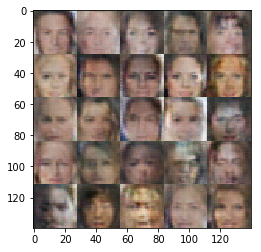

Epoch 1/1... Discriminator Loss: 0.6013... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 1.2097
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 0.2217... Generator Loss: 2.0021
Epoch 1/1... Discriminator Loss: 0.0660... Generator Loss: 3.9767
Epoch 1/1... Discriminator Loss: 0.0338... Generator Loss: 6.3821
Epoch 1/1... Discriminator Loss: 0.1316... Generator Loss: 11.6083
Epoch 1/1... Discriminator Loss: 0.0228... Generator Loss: 14.1533
Epoch 1/1... Discriminator Loss: 0.0143... Generator Loss: 8.3631
Epoch 1/1... Discriminator Loss: 0.0451... Generator Loss: 4.3989
out_channel_dim 3


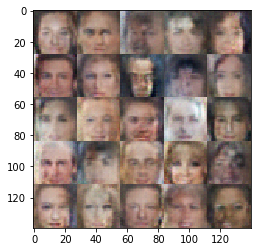

Epoch 1/1... Discriminator Loss: 0.0864... Generator Loss: 3.6465
Epoch 1/1... Discriminator Loss: 0.0367... Generator Loss: 4.3690
Epoch 1/1... Discriminator Loss: 0.1730... Generator Loss: 2.8463
Epoch 1/1... Discriminator Loss: 0.1502... Generator Loss: 2.4988
Epoch 1/1... Discriminator Loss: 0.0385... Generator Loss: 4.4400
Epoch 1/1... Discriminator Loss: 0.3753... Generator Loss: 1.5315
Epoch 1/1... Discriminator Loss: 0.1122... Generator Loss: 5.6514
Epoch 1/1... Discriminator Loss: 0.0081... Generator Loss: 7.6252
Epoch 1/1... Discriminator Loss: 0.1329... Generator Loss: 2.6818
Epoch 1/1... Discriminator Loss: 0.0518... Generator Loss: 4.7074
out_channel_dim 3


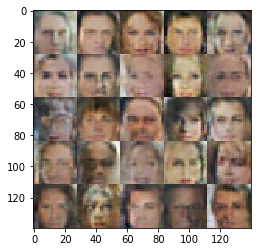

Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 16.2138
Epoch 1/1... Discriminator Loss: 2.2947... Generator Loss: 4.7400
Epoch 1/1... Discriminator Loss: 0.0560... Generator Loss: 4.0298
Epoch 1/1... Discriminator Loss: 0.0132... Generator Loss: 11.7090
Epoch 1/1... Discriminator Loss: 0.0480... Generator Loss: 4.7103
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 0.4266... Generator Loss: 1.4268
Epoch 1/1... Discriminator Loss: 2.5443... Generator Loss: 0.1641
Epoch 1/1... Discriminator Loss: 0.3743... Generator Loss: 1.6187
Epoch 1/1... Discriminator Loss: 0.0575... Generator Loss: 7.3048
out_channel_dim 3


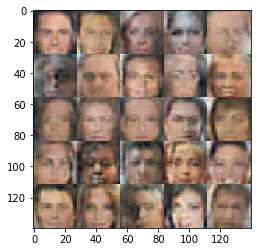

Epoch 1/1... Discriminator Loss: 0.1771... Generator Loss: 2.7866
Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 4.7140
Epoch 1/1... Discriminator Loss: 0.0993... Generator Loss: 7.2040
Epoch 1/1... Discriminator Loss: 0.0421... Generator Loss: 4.7210
Epoch 1/1... Discriminator Loss: 0.1780... Generator Loss: 2.3653
Epoch 1/1... Discriminator Loss: 0.0994... Generator Loss: 7.1543
Epoch 1/1... Discriminator Loss: 0.0206... Generator Loss: 13.0070
Epoch 1/1... Discriminator Loss: 0.2755... Generator Loss: 1.7951
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 0.0282... Generator Loss: 6.1680
out_channel_dim 3


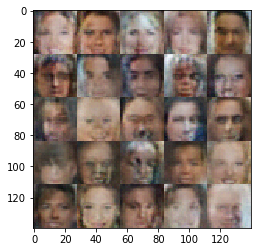

Epoch 1/1... Discriminator Loss: 0.0252... Generator Loss: 7.0887
Epoch 1/1... Discriminator Loss: 0.0802... Generator Loss: 7.3430
Epoch 1/1... Discriminator Loss: 0.0531... Generator Loss: 4.1832
Epoch 1/1... Discriminator Loss: 0.0808... Generator Loss: 7.7345
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 5.0571
Epoch 1/1... Discriminator Loss: 0.3202... Generator Loss: 4.0530
Epoch 1/1... Discriminator Loss: 0.1747... Generator Loss: 2.3928
Epoch 1/1... Discriminator Loss: 0.1209... Generator Loss: 6.1013
Epoch 1/1... Discriminator Loss: 0.0270... Generator Loss: 5.0457
Epoch 1/1... Discriminator Loss: 0.5879... Generator Loss: 1.1841
out_channel_dim 3


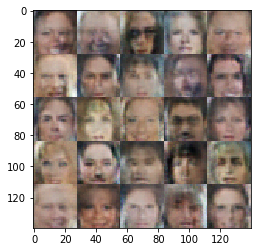

Epoch 1/1... Discriminator Loss: 0.1538... Generator Loss: 2.4982
Epoch 1/1... Discriminator Loss: 0.3486... Generator Loss: 1.6078
Epoch 1/1... Discriminator Loss: 0.0368... Generator Loss: 6.0878
Epoch 1/1... Discriminator Loss: 0.0808... Generator Loss: 3.7654
Epoch 1/1... Discriminator Loss: 0.0150... Generator Loss: 5.5905
Epoch 1/1... Discriminator Loss: 0.0185... Generator Loss: 8.8206
Epoch 1/1... Discriminator Loss: 0.0249... Generator Loss: 4.9153
Epoch 1/1... Discriminator Loss: 0.0171... Generator Loss: 9.2000
Epoch 1/1... Discriminator Loss: 0.0186... Generator Loss: 4.9750
Epoch 1/1... Discriminator Loss: 0.0790... Generator Loss: 4.5309
out_channel_dim 3


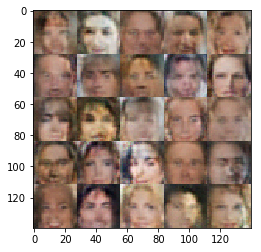

Epoch 1/1... Discriminator Loss: 0.0193... Generator Loss: 7.0453
Epoch 1/1... Discriminator Loss: 0.0386... Generator Loss: 10.8006
Epoch 1/1... Discriminator Loss: 0.0389... Generator Loss: 5.5975
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 7.2669
Epoch 1/1... Discriminator Loss: 0.2368... Generator Loss: 2.6913
Epoch 1/1... Discriminator Loss: 0.0967... Generator Loss: 8.1227
Epoch 1/1... Discriminator Loss: 0.1414... Generator Loss: 2.5077
Epoch 1/1... Discriminator Loss: 0.0375... Generator Loss: 5.7994
Epoch 1/1... Discriminator Loss: 0.0860... Generator Loss: 3.3319
Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 8.7049
out_channel_dim 3


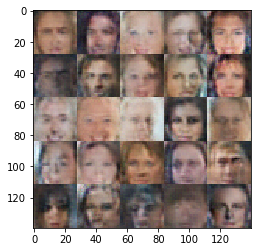

Epoch 1/1... Discriminator Loss: 0.3044... Generator Loss: 4.8547
Epoch 1/1... Discriminator Loss: 0.0920... Generator Loss: 10.0143
Epoch 1/1... Discriminator Loss: 0.0209... Generator Loss: 14.2139
Epoch 1/1... Discriminator Loss: 0.0218... Generator Loss: 10.9710
Epoch 1/1... Discriminator Loss: 0.0387... Generator Loss: 4.5616
Epoch 1/1... Discriminator Loss: 0.3092... Generator Loss: 4.3694
Epoch 1/1... Discriminator Loss: 0.0155... Generator Loss: 6.6387
Epoch 1/1... Discriminator Loss: 0.1525... Generator Loss: 2.8030
Epoch 1/1... Discriminator Loss: 0.0166... Generator Loss: 5.3188
Epoch 1/1... Discriminator Loss: 0.0071... Generator Loss: 5.7923
out_channel_dim 3


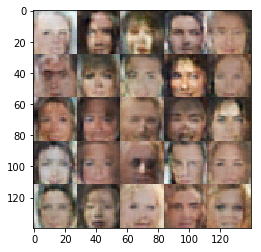

Epoch 1/1... Discriminator Loss: 0.0313... Generator Loss: 7.5006
Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 7.3202
Epoch 1/1... Discriminator Loss: 0.0692... Generator Loss: 4.1556
Epoch 1/1... Discriminator Loss: 0.0833... Generator Loss: 3.6765
Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 4.5832
Epoch 1/1... Discriminator Loss: 0.0391... Generator Loss: 8.9366
Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 0.0110... Generator Loss: 7.4908
Epoch 1/1... Discriminator Loss: 0.2386... Generator Loss: 6.7913
Epoch 1/1... Discriminator Loss: 0.2980... Generator Loss: 1.9232
out_channel_dim 3


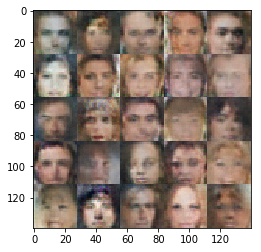

Epoch 1/1... Discriminator Loss: 0.0755... Generator Loss: 3.5884
Epoch 1/1... Discriminator Loss: 0.0453... Generator Loss: 5.8794
Epoch 1/1... Discriminator Loss: 0.0172... Generator Loss: 5.8919
Epoch 1/1... Discriminator Loss: 0.1073... Generator Loss: 3.6331
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 2.1953... Generator Loss: 0.1808
Epoch 1/1... Discriminator Loss: 0.0420... Generator Loss: 5.9703
Epoch 1/1... Discriminator Loss: 0.4229... Generator Loss: 1.6380
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 0.2723... Generator Loss: 1.9372
out_channel_dim 3


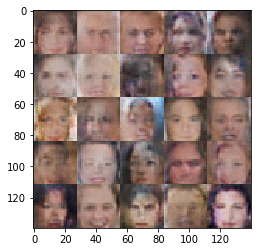

Epoch 1/1... Discriminator Loss: 0.5190... Generator Loss: 1.1888
Epoch 1/1... Discriminator Loss: 0.0998... Generator Loss: 5.6335
Epoch 1/1... Discriminator Loss: 0.2010... Generator Loss: 5.0217
Epoch 1/1... Discriminator Loss: 0.0232... Generator Loss: 8.0979
Epoch 1/1... Discriminator Loss: 0.1198... Generator Loss: 5.8620
Epoch 1/1... Discriminator Loss: 0.0093... Generator Loss: 6.5478
Epoch 1/1... Discriminator Loss: 0.0443... Generator Loss: 10.1952
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 0.0505... Generator Loss: 7.7508
Epoch 1/1... Discriminator Loss: 0.0341... Generator Loss: 9.5786
out_channel_dim 3


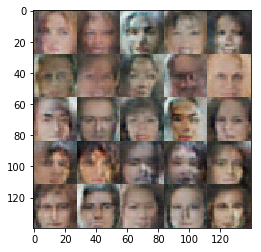

Epoch 1/1... Discriminator Loss: 0.2049... Generator Loss: 2.5431
Epoch 1/1... Discriminator Loss: 0.1409... Generator Loss: 2.4002
Epoch 1/1... Discriminator Loss: 0.6080... Generator Loss: 1.1242
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 1.4893
Epoch 1/1... Discriminator Loss: 0.0418... Generator Loss: 4.0459
Epoch 1/1... Discriminator Loss: 0.0461... Generator Loss: 5.9281
Epoch 1/1... Discriminator Loss: 0.0323... Generator Loss: 5.4283
Epoch 1/1... Discriminator Loss: 0.2178... Generator Loss: 4.6194
Epoch 1/1... Discriminator Loss: 1.6584... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 0.0843... Generator Loss: 3.0854
out_channel_dim 3


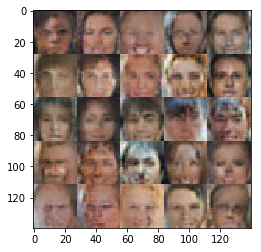

Epoch 1/1... Discriminator Loss: 0.0435... Generator Loss: 6.2121
Epoch 1/1... Discriminator Loss: 0.1368... Generator Loss: 8.4818
Epoch 1/1... Discriminator Loss: 0.1114... Generator Loss: 3.6242
Epoch 1/1... Discriminator Loss: 0.7215... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 0.1515... Generator Loss: 2.7215
Epoch 1/1... Discriminator Loss: 0.2373... Generator Loss: 6.2129
Epoch 1/1... Discriminator Loss: 0.0864... Generator Loss: 3.4259
Epoch 1/1... Discriminator Loss: 0.1346... Generator Loss: 9.0762
Epoch 1/1... Discriminator Loss: 0.0883... Generator Loss: 3.6752
Epoch 1/1... Discriminator Loss: 0.0218... Generator Loss: 5.8003
out_channel_dim 3


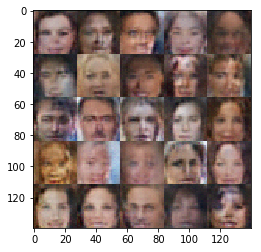

Epoch 1/1... Discriminator Loss: 0.0254... Generator Loss: 11.8839
Epoch 1/1... Discriminator Loss: 0.0140... Generator Loss: 6.6754
Epoch 1/1... Discriminator Loss: 0.1242... Generator Loss: 3.1434
Epoch 1/1... Discriminator Loss: 0.0553... Generator Loss: 3.6169
Epoch 1/1... Discriminator Loss: 0.3014... Generator Loss: 1.8965
Epoch 1/1... Discriminator Loss: 0.0373... Generator Loss: 9.9619
Epoch 1/1... Discriminator Loss: 1.6830... Generator Loss: 0.2643
Epoch 1/1... Discriminator Loss: 0.0638... Generator Loss: 11.4138
Epoch 1/1... Discriminator Loss: 0.0310... Generator Loss: 4.5734
Epoch 1/1... Discriminator Loss: 0.0810... Generator Loss: 3.3074
out_channel_dim 3


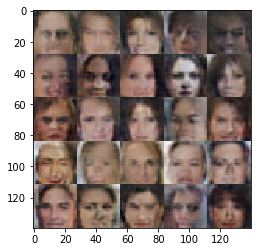

Epoch 1/1... Discriminator Loss: 0.4022... Generator Loss: 1.3008
Epoch 1/1... Discriminator Loss: 0.1791... Generator Loss: 11.9641
Epoch 1/1... Discriminator Loss: 0.0262... Generator Loss: 4.6031
Epoch 1/1... Discriminator Loss: 0.1427... Generator Loss: 3.6124
Epoch 1/1... Discriminator Loss: 0.7237... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 0.0333... Generator Loss: 16.1700
Epoch 1/1... Discriminator Loss: 0.0401... Generator Loss: 5.1508
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 3.4321
Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 2.0295
Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 2.7646
out_channel_dim 3


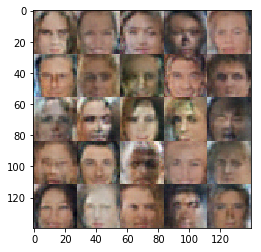

Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 0.2757... Generator Loss: 3.4168
Epoch 1/1... Discriminator Loss: 0.0700... Generator Loss: 6.7681
Epoch 1/1... Discriminator Loss: 0.4263... Generator Loss: 1.4565
Epoch 1/1... Discriminator Loss: 0.1515... Generator Loss: 9.6491
Epoch 1/1... Discriminator Loss: 0.2067... Generator Loss: 2.5528
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 0.0144... Generator Loss: 10.8949
Epoch 1/1... Discriminator Loss: 0.0728... Generator Loss: 8.8656
Epoch 1/1... Discriminator Loss: 0.1442... Generator Loss: 3.8776
out_channel_dim 3


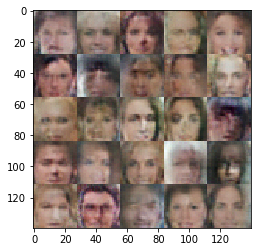

Epoch 1/1... Discriminator Loss: 0.0454... Generator Loss: 7.0431
Epoch 1/1... Discriminator Loss: 0.1990... Generator Loss: 4.0424
Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 5.6377
Epoch 1/1... Discriminator Loss: 0.0257... Generator Loss: 10.5202
Epoch 1/1... Discriminator Loss: 0.0666... Generator Loss: 6.3956
Epoch 1/1... Discriminator Loss: 0.0117... Generator Loss: 15.1345
Epoch 1/1... Discriminator Loss: 0.0189... Generator Loss: 9.0766
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 5.7977
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 1.2037
Epoch 1/1... Discriminator Loss: 0.4408... Generator Loss: 1.4911
out_channel_dim 3


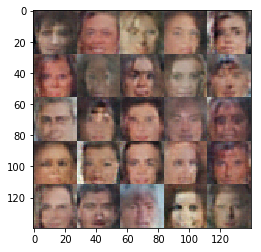

Epoch 1/1... Discriminator Loss: 0.0278... Generator Loss: 7.4628
Epoch 1/1... Discriminator Loss: 0.0606... Generator Loss: 6.3562
Epoch 1/1... Discriminator Loss: 0.4682... Generator Loss: 1.3610
Epoch 1/1... Discriminator Loss: 0.1056... Generator Loss: 5.8382
Epoch 1/1... Discriminator Loss: 0.2071... Generator Loss: 2.2761
Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 3.6997
Epoch 1/1... Discriminator Loss: 0.0446... Generator Loss: 11.0702
Epoch 1/1... Discriminator Loss: 0.0481... Generator Loss: 6.6114
Epoch 1/1... Discriminator Loss: 0.0078... Generator Loss: 6.8276
Epoch 1/1... Discriminator Loss: 0.0666... Generator Loss: 6.4298
out_channel_dim 3


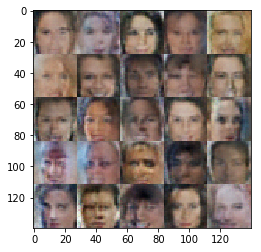

Epoch 1/1... Discriminator Loss: 0.0916... Generator Loss: 2.8369
Epoch 1/1... Discriminator Loss: 0.0227... Generator Loss: 9.5064
Epoch 1/1... Discriminator Loss: 0.0623... Generator Loss: 7.5490
Epoch 1/1... Discriminator Loss: 0.0122... Generator Loss: 7.0791
Epoch 1/1... Discriminator Loss: 0.3290... Generator Loss: 1.7458
Epoch 1/1... Discriminator Loss: 0.0079... Generator Loss: 7.1664
Epoch 1/1... Discriminator Loss: 0.1155... Generator Loss: 2.9372
Epoch 1/1... Discriminator Loss: 0.0727... Generator Loss: 3.3003
Epoch 1/1... Discriminator Loss: 0.0630... Generator Loss: 3.3115
Epoch 1/1... Discriminator Loss: 0.0296... Generator Loss: 7.3640
out_channel_dim 3


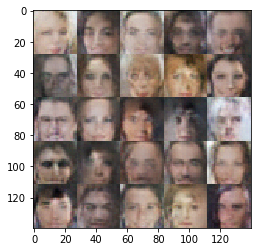

Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 6.3142
Epoch 1/1... Discriminator Loss: 0.0142... Generator Loss: 5.8268
Epoch 1/1... Discriminator Loss: 0.1027... Generator Loss: 3.1901
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.4823
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 15.3003
Epoch 1/1... Discriminator Loss: 2.3424... Generator Loss: 3.2382
Epoch 1/1... Discriminator Loss: 1.7639... Generator Loss: 0.3741
Epoch 1/1... Discriminator Loss: 0.5505... Generator Loss: 2.2140
Epoch 1/1... Discriminator Loss: 0.3945... Generator Loss: 2.4369
Epoch 1/1... Discriminator Loss: 0.2986... Generator Loss: 1.9298
out_channel_dim 3


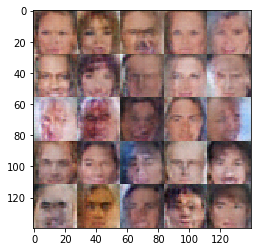

Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 1.3331
Epoch 1/1... Discriminator Loss: 0.1043... Generator Loss: 2.6993
Epoch 1/1... Discriminator Loss: 0.0339... Generator Loss: 7.4648
Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 3.5583
Epoch 1/1... Discriminator Loss: 1.8987... Generator Loss: 0.3507
Epoch 1/1... Discriminator Loss: 0.3104... Generator Loss: 11.1796
Epoch 1/1... Discriminator Loss: 0.0336... Generator Loss: 7.0158
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 0.6887
out_channel_dim 3


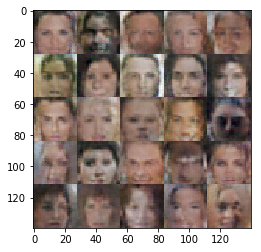

Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 1.2406
Epoch 1/1... Discriminator Loss: 0.0725... Generator Loss: 8.8738
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 2.2039
Epoch 1/1... Discriminator Loss: 0.7279... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 0.5403... Generator Loss: 1.2381
Epoch 1/1... Discriminator Loss: 0.0174... Generator Loss: 10.7299
Epoch 1/1... Discriminator Loss: 0.0135... Generator Loss: 7.2538
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 0.1230... Generator Loss: 3.9833
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 12.0332
out_channel_dim 3


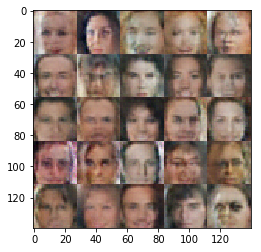

Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 0.0318... Generator Loss: 5.3453
Epoch 1/1... Discriminator Loss: 0.3159... Generator Loss: 1.6249
Epoch 1/1... Discriminator Loss: 0.0805... Generator Loss: 4.6082
Epoch 1/1... Discriminator Loss: 0.0428... Generator Loss: 4.4580
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 0.0331... Generator Loss: 9.8136
Epoch 1/1... Discriminator Loss: 0.0461... Generator Loss: 5.2895
Epoch 1/1... Discriminator Loss: 0.0189... Generator Loss: 5.7811
Epoch 1/1... Discriminator Loss: 0.0447... Generator Loss: 8.0101
out_channel_dim 3


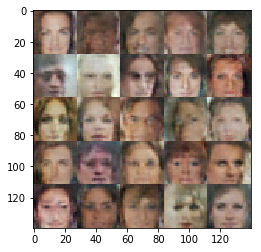

Epoch 1/1... Discriminator Loss: 0.0394... Generator Loss: 5.5311
Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 13.4445
Epoch 1/1... Discriminator Loss: 0.0311... Generator Loss: 6.4892
Epoch 1/1... Discriminator Loss: 0.0769... Generator Loss: 3.3313
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 0.2030... Generator Loss: 2.1588
Epoch 1/1... Discriminator Loss: 0.1539... Generator Loss: 2.2003
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 5.1115
Epoch 1/1... Discriminator Loss: 0.0304... Generator Loss: 4.5346
Epoch 1/1... Discriminator Loss: 0.0504... Generator Loss: 12.5878
out_channel_dim 3


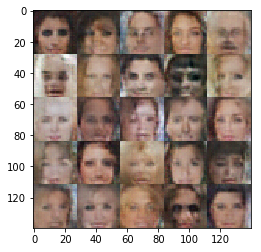

Epoch 1/1... Discriminator Loss: 0.0313... Generator Loss: 7.1874
Epoch 1/1... Discriminator Loss: 0.3226... Generator Loss: 5.1037
Epoch 1/1... Discriminator Loss: 0.7541... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 0.4269... Generator Loss: 1.3417
Epoch 1/1... Discriminator Loss: 0.0076... Generator Loss: 8.2622
Epoch 1/1... Discriminator Loss: 0.0197... Generator Loss: 10.4084
Epoch 1/1... Discriminator Loss: 0.1368... Generator Loss: 7.6461
Epoch 1/1... Discriminator Loss: 0.0485... Generator Loss: 3.8530
Epoch 1/1... Discriminator Loss: 0.1246... Generator Loss: 2.6751
Epoch 1/1... Discriminator Loss: 0.0767... Generator Loss: 5.0911
out_channel_dim 3


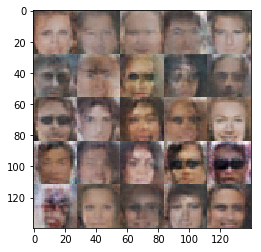

Epoch 1/1... Discriminator Loss: 0.0278... Generator Loss: 6.1196
Epoch 1/1... Discriminator Loss: 2.3439... Generator Loss: 0.2254
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.9584
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 0.2275... Generator Loss: 2.6300
Epoch 1/1... Discriminator Loss: 0.0449... Generator Loss: 6.4917
Epoch 1/1... Discriminator Loss: 0.1732... Generator Loss: 2.5171
Epoch 1/1... Discriminator Loss: 0.8363... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 0.0180... Generator Loss: 5.6087
Epoch 1/1... Discriminator Loss: 0.1257... Generator Loss: 2.5249
out_channel_dim 3


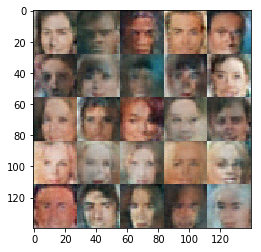

Epoch 1/1... Discriminator Loss: 0.0607... Generator Loss: 8.1384
Epoch 1/1... Discriminator Loss: 0.2167... Generator Loss: 2.3218
Epoch 1/1... Discriminator Loss: 0.0513... Generator Loss: 3.4632
Epoch 1/1... Discriminator Loss: 0.2490... Generator Loss: 12.2225
Epoch 1/1... Discriminator Loss: 0.0481... Generator Loss: 5.7270
Epoch 1/1... Discriminator Loss: 0.0625... Generator Loss: 4.3043
Epoch 1/1... Discriminator Loss: 0.0337... Generator Loss: 5.2746
Epoch 1/1... Discriminator Loss: 0.0866... Generator Loss: 3.6482
Epoch 1/1... Discriminator Loss: 0.1319... Generator Loss: 4.6594
Epoch 1/1... Discriminator Loss: 0.0284... Generator Loss: 5.8638
out_channel_dim 3


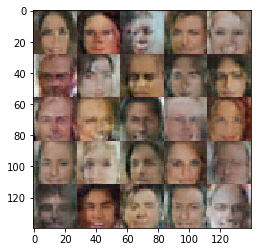

Epoch 1/1... Discriminator Loss: 0.0545... Generator Loss: 9.7947
Epoch 1/1... Discriminator Loss: 0.2245... Generator Loss: 7.0265
Epoch 1/1... Discriminator Loss: 0.0486... Generator Loss: 4.5901
Epoch 1/1... Discriminator Loss: 0.3278... Generator Loss: 1.7944
Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 6.7691
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 5.4675
Epoch 1/1... Discriminator Loss: 0.0284... Generator Loss: 4.4852
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 0.0324... Generator Loss: 5.2565
Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 1.0531
out_channel_dim 3


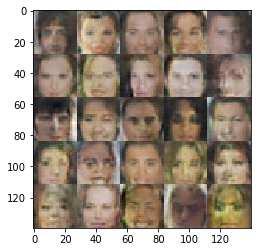

Epoch 1/1... Discriminator Loss: 0.0544... Generator Loss: 11.6417
Epoch 1/1... Discriminator Loss: 0.0245... Generator Loss: 4.6559
Epoch 1/1... Discriminator Loss: 0.1624... Generator Loss: 2.3618
Epoch 1/1... Discriminator Loss: 0.0469... Generator Loss: 3.9440
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 0.0322... Generator Loss: 5.2315
Epoch 1/1... Discriminator Loss: 0.0182... Generator Loss: 7.9825
Epoch 1/1... Discriminator Loss: 0.1822... Generator Loss: 2.1548
Epoch 1/1... Discriminator Loss: 0.0287... Generator Loss: 7.7852
Epoch 1/1... Discriminator Loss: 0.0701... Generator Loss: 4.3546
out_channel_dim 3


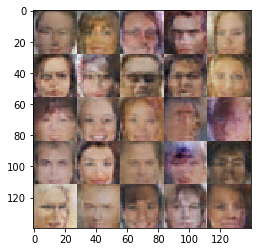

Epoch 1/1... Discriminator Loss: 0.1175... Generator Loss: 2.6962
Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 1.2474
Epoch 1/1... Discriminator Loss: 0.0987... Generator Loss: 12.0514
Epoch 1/1... Discriminator Loss: 0.0072... Generator Loss: 6.3948
Epoch 1/1... Discriminator Loss: 0.3518... Generator Loss: 1.8104
Epoch 1/1... Discriminator Loss: 0.0457... Generator Loss: 3.9505
Epoch 1/1... Discriminator Loss: 0.2351... Generator Loss: 2.0873
Epoch 1/1... Discriminator Loss: 0.0249... Generator Loss: 7.6581
Epoch 1/1... Discriminator Loss: 0.3570... Generator Loss: 1.5012
Epoch 1/1... Discriminator Loss: 0.0687... Generator Loss: 4.0160
out_channel_dim 3


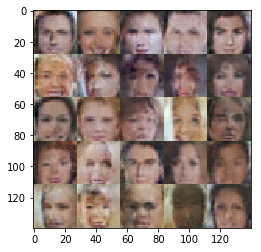

Epoch 1/1... Discriminator Loss: 0.0136... Generator Loss: 6.8584
Epoch 1/1... Discriminator Loss: 0.3143... Generator Loss: 2.2187
Epoch 1/1... Discriminator Loss: 0.0290... Generator Loss: 9.3055
Epoch 1/1... Discriminator Loss: 0.3504... Generator Loss: 1.7613
Epoch 1/1... Discriminator Loss: 0.0545... Generator Loss: 3.8266
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 12.2654
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.4532
Epoch 1/1... Discriminator Loss: 0.2899... Generator Loss: 1.7059
Epoch 1/1... Discriminator Loss: 0.0126... Generator Loss: 9.3415
Epoch 1/1... Discriminator Loss: 0.0877... Generator Loss: 3.3346
out_channel_dim 3


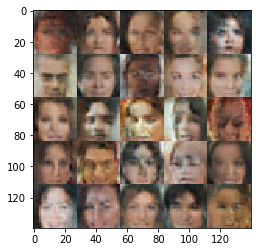

Epoch 1/1... Discriminator Loss: 0.0439... Generator Loss: 3.9257
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 7.0791
Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 6.5695
Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 1.3865
Epoch 1/1... Discriminator Loss: 0.0696... Generator Loss: 12.4276
Epoch 1/1... Discriminator Loss: 0.0355... Generator Loss: 7.1034
Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 9.5610
Epoch 1/1... Discriminator Loss: 0.2676... Generator Loss: 5.9240
Epoch 1/1... Discriminator Loss: 0.1630... Generator Loss: 2.6398
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.5170
out_channel_dim 3


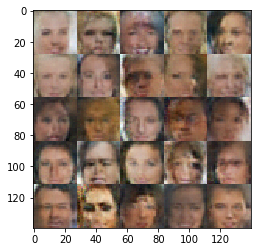

Epoch 1/1... Discriminator Loss: 0.0897... Generator Loss: 6.4602
Epoch 1/1... Discriminator Loss: 0.0619... Generator Loss: 4.2229
Epoch 1/1... Discriminator Loss: 0.0169... Generator Loss: 5.0493
Epoch 1/1... Discriminator Loss: 0.0191... Generator Loss: 12.0002
Epoch 1/1... Discriminator Loss: 0.0994... Generator Loss: 2.8360
Epoch 1/1... Discriminator Loss: 0.1479... Generator Loss: 5.3143
Epoch 1/1... Discriminator Loss: 0.5907... Generator Loss: 1.2263
Epoch 1/1... Discriminator Loss: 0.0287... Generator Loss: 9.9165
Epoch 1/1... Discriminator Loss: 0.0230... Generator Loss: 13.9002
Epoch 1/1... Discriminator Loss: 0.0382... Generator Loss: 14.1578
out_channel_dim 3


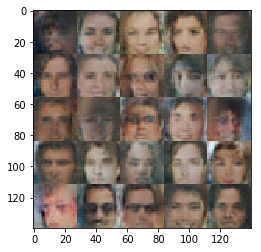

Epoch 1/1... Discriminator Loss: 0.0290... Generator Loss: 7.5548
Epoch 1/1... Discriminator Loss: 0.0352... Generator Loss: 7.0351
Epoch 1/1... Discriminator Loss: 0.0547... Generator Loss: 11.3515
Epoch 1/1... Discriminator Loss: 0.0162... Generator Loss: 6.6280
Epoch 1/1... Discriminator Loss: 0.0345... Generator Loss: 5.6202
Epoch 1/1... Discriminator Loss: 0.0559... Generator Loss: 4.1928
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 0.0197... Generator Loss: 5.1729
Epoch 1/1... Discriminator Loss: 0.0769... Generator Loss: 9.9501
Epoch 1/1... Discriminator Loss: 0.0518... Generator Loss: 5.0952
out_channel_dim 3


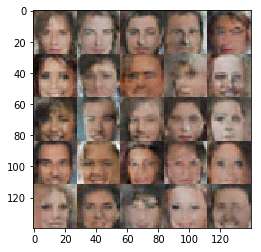

Epoch 1/1... Discriminator Loss: 0.0128... Generator Loss: 12.4087
Epoch 1/1... Discriminator Loss: 0.0707... Generator Loss: 3.5061
Epoch 1/1... Discriminator Loss: 0.0060... Generator Loss: 7.2875
Epoch 1/1... Discriminator Loss: 0.4609... Generator Loss: 1.3702
Epoch 1/1... Discriminator Loss: 0.0114... Generator Loss: 8.3002
Epoch 1/1... Discriminator Loss: 0.0476... Generator Loss: 9.3046
Epoch 1/1... Discriminator Loss: 0.0785... Generator Loss: 5.9379
Epoch 1/1... Discriminator Loss: 0.6637... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 0.0356... Generator Loss: 4.2509
Epoch 1/1... Discriminator Loss: 0.1985... Generator Loss: 5.1569
out_channel_dim 3


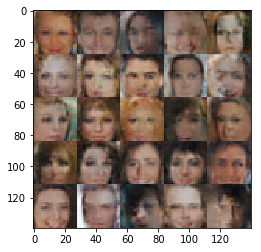

Epoch 1/1... Discriminator Loss: 0.0731... Generator Loss: 3.2839
Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 8.3765
Epoch 1/1... Discriminator Loss: 0.0246... Generator Loss: 5.4331
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 4.5180
Epoch 1/1... Discriminator Loss: 3.4762... Generator Loss: 0.0644
Epoch 1/1... Discriminator Loss: 0.2408... Generator Loss: 2.7281
Epoch 1/1... Discriminator Loss: 0.0678... Generator Loss: 4.2462
Epoch 1/1... Discriminator Loss: 0.0363... Generator Loss: 4.2594
Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 1.2651
out_channel_dim 3


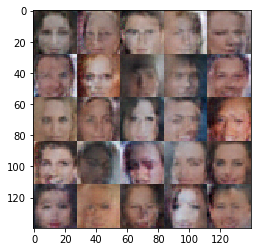

Epoch 1/1... Discriminator Loss: 0.2978... Generator Loss: 2.1805
Epoch 1/1... Discriminator Loss: 0.0471... Generator Loss: 4.7098
Epoch 1/1... Discriminator Loss: 0.0992... Generator Loss: 3.8229
Epoch 1/1... Discriminator Loss: 0.5130... Generator Loss: 1.4179
Epoch 1/1... Discriminator Loss: 0.1309... Generator Loss: 2.6775
Epoch 1/1... Discriminator Loss: 0.3389... Generator Loss: 1.6561
Epoch 1/1... Discriminator Loss: 0.0830... Generator Loss: 12.0106
Epoch 1/1... Discriminator Loss: 0.0177... Generator Loss: 6.2258
Epoch 1/1... Discriminator Loss: 0.4844... Generator Loss: 1.2456
Epoch 1/1... Discriminator Loss: 0.0992... Generator Loss: 3.0564
out_channel_dim 3


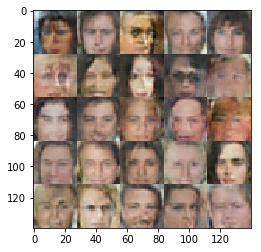

Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 9.2118
Epoch 1/1... Discriminator Loss: 0.0584... Generator Loss: 3.6621
Epoch 1/1... Discriminator Loss: 0.0484... Generator Loss: 4.1345
Epoch 1/1... Discriminator Loss: 0.1142... Generator Loss: 10.5775
Epoch 1/1... Discriminator Loss: 0.0048... Generator Loss: 6.7647
Epoch 1/1... Discriminator Loss: 0.0108... Generator Loss: 5.9536
Epoch 1/1... Discriminator Loss: 0.1335... Generator Loss: 2.4743
Epoch 1/1... Discriminator Loss: 0.2074... Generator Loss: 2.2063
Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 1.4292
Epoch 1/1... Discriminator Loss: 0.3132... Generator Loss: 3.9068
out_channel_dim 3


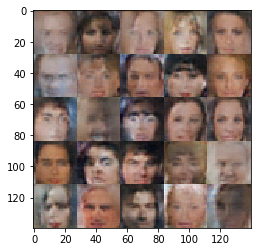

Epoch 1/1... Discriminator Loss: 0.4663... Generator Loss: 1.9565
Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 0.0672... Generator Loss: 8.8546
Epoch 1/1... Discriminator Loss: 0.1951... Generator Loss: 2.4805
Epoch 1/1... Discriminator Loss: 0.0230... Generator Loss: 10.2163
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 1.5950
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 0.0384... Generator Loss: 12.5263
Epoch 1/1... Discriminator Loss: 0.0242... Generator Loss: 5.7732
Epoch 1/1... Discriminator Loss: 0.4260... Generator Loss: 1.3162
out_channel_dim 3


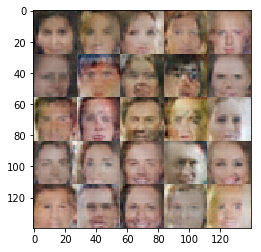

Epoch 1/1... Discriminator Loss: 0.0210... Generator Loss: 7.5050
Epoch 1/1... Discriminator Loss: 0.5666... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 11.2185


In [25]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.